## Building a variational autoencoder with the aim of generating new anime faces derived from the anime faces dataset

### The Theory

An autoencoder is made up of 2 parts, encoder and decoder. 

The encoder takes an image and maps in onto a latent vector space, usually of smaller dimensions to that of the original input.

The decoder then takes that encoded vector and trys to reconstruct the original image. 

If the encoder and decoder do a good job of mapping the original image into a smaller vector space and then reconstructing the image, then we have a data compression algorithm.

An variational autoencoder has an encoder and decoder but also has a regulizer which is trying restrict the values of the encodings to within a certain range, usually mean zero and standard deviation of one.

This means that by sampling random vectors from the encoded vector space, we have a good chance of reconstructing a face.

It is very unlikely that we will randomly choose a vector which corresponds exactly with one of the images the VAE was trained on. 

But the VAE should have the ability to interpolate between close images there by generating new faces, arbeit ones based on other images.


In [16]:
#IMPORTS

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import cv2

In [17]:
#LOADING THE DATA INTO A NUMPY ARRAY


dataset_path = '../input/data/data'
num_images_to_load = 500

x_data = []
for png in tqdm(os.listdir(dataset_path)):
    if len(x_data) >= num_images_to_load:
        break

    path = os.path.join(dataset_path, png)
    image = plt.imread(path)
    image = image.astype('float32')
    x_data.append(image)

x_data = np.array(x_data)

  2%|▏         | 490/21551 [00:00<00:21, 975.51it/s]


In [18]:
# KERAS IMPORTS

import keras

from keras.models import Sequential, Model, Input

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda

from keras.layers import Flatten
from keras.layers import Reshape

from keras.layers import Add, Multiply

from keras.losses import mse, binary_crossentropy

import keras.backend as K

In [19]:
#SET A SEED FOR REPRODUCABILITY
np.random.seed(20)

#NUMBER OF DIMENSIONS IN THE ENCODED LAYER
latent_dims = 512

## Building the encoder

The encoder compresses the image via a series of convolutions into a smaller dimensional space (z).

The output is split into 2 blocks, the mean (mu) and log_variance (log_var), which are then recombined to predict a distribution rather than a value.
* The mean to predict the mean of the distribution.
* log_variance, because we cant have negative variance so by exponentiating the log_var we will always get a positive number. 
* A second input(epsilon) for inputing random numbers to simulate sampling randomly from latend distribution. 
* having the random numbers input as a seperate Input allows back propagation proceed normally.
* z is the output of the encoderer, z = mean + sigma * epsilon

In [20]:
#ENCODER
#BUILT WITH FUNCTIONAL MODEL DUE TO THE MULTIPLE INPUTS AND OUTPUTS

encoder_in = Input(shape=(64,64,3))   ##INPUT FOR THE IMAGE

encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64,64,3))(encoder_in)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same')(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same')(encoder_l3)
encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

flatten = Flatten()(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z)
encoder.summary()


/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   2432        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 64, 64, 32)   128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 64, 64, 32)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv2d_7 (

In [21]:
# DECODER
# BUILT WITH SEQUENTIAL MODEL AS NO BRANCHING IS REQUIRED

decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Dense(8192))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Reshape(target_shape=(4,4,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))


decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('sigmoid'))

decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_20 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_21 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_21 (Activation)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
__________

In [22]:
# COMBINE ENCODER AND DECODER THE COMPLETE THE VARIATIONAL AUTO ENCODER

vae_preds = decoder(z)
vae = Model([encoder_in, epsilon], vae_preds)

vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   2432        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 64, 64, 32)   128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 64, 64, 32)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv2d_7 (

## Loss Functions

Reconstruction loss 
* Measures how accurately the images are reconstructed.
* Simply Mean squared error, but if I use the built in MSE function gives a dimension miss match error. 

kl_loss
* kullback leibler loss
* applied to the latent dimensions
* The formula is a bit beyond my understanding, but this tries pull the mean and standard deviation of (z) to zero and one. 

The reconstruction_loss and the kl_loss need to work well together to variational auto encoder to work as we wish
* If the kl_loss is to weak and the reconstruction_loss too strong, then the VAE will work well in reconstructing the original images, but there maybe lots of space between encodings resulting in vectors which generate noise or lousy faces.
* If kl_loss is too strong and reconstruction loss is too weak then all the encodings will occupy the same space. meaning all encoded vectors will try to output similar faces.

vae_loss is a summation of reconstruction loss and kl_loss.
With some experimentation I found scaling the kl_loss by 0.03 seemed to give the best results. 
Other research has suggested that reconstruction_loss should be the sum of the errors rather than the mean. Negating the need to scale the kl_loss. 
Should the kl_loss be a summation also? I need to do more research. 

In [23]:
# MY LOSS FUNCTIONS

def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help


In [24]:
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

In [30]:
vae.fit(x_data,x_data, epochs=10, batch_size=64)

Epoch 1/10
500/500 [==============================] - 28s 57ms/step - loss: 0.0834 - reconstruction_loss: 0.0800 - kl_loss: 0.1133
Epoch 2/10
500/500 [==============================] - 28s 55ms/step - loss: 0.0755 - reconstruction_loss: 0.0724 - kl_loss: 0.1021
Epoch 3/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0713 - reconstruction_loss: 0.0683 - kl_loss: 0.0984
Epoch 4/10
500/500 [==============================] - 28s 57ms/step - loss: 0.0681 - reconstruction_loss: 0.0650 - kl_loss: 0.1047
Epoch 5/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0653 - reconstruction_loss: 0.0624 - kl_loss: 0.0968
Epoch 6/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0631 - reconstruction_loss: 0.0604 - kl_loss: 0.0886
Epoch 7/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0617 - reconstruction_loss: 0.0591 - kl_loss: 0.0873
Epoch 8/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0608 

In [31]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(20,20))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

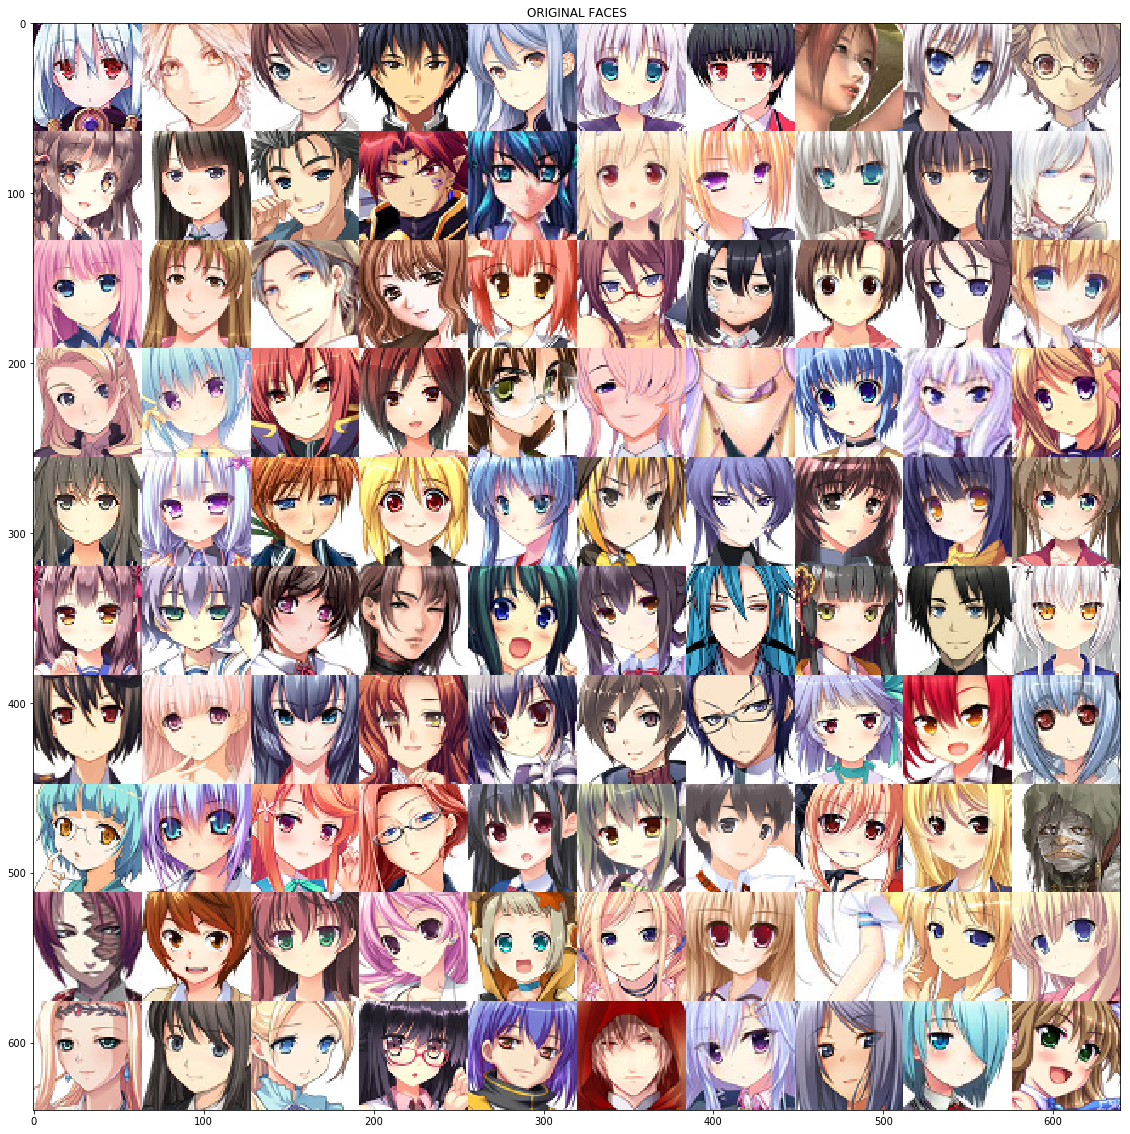

In [32]:
# ORIGINAL IMAGES

predictions = x_data[:100]
plot_images(10,10,predictions,"ORIGINAL FACES")

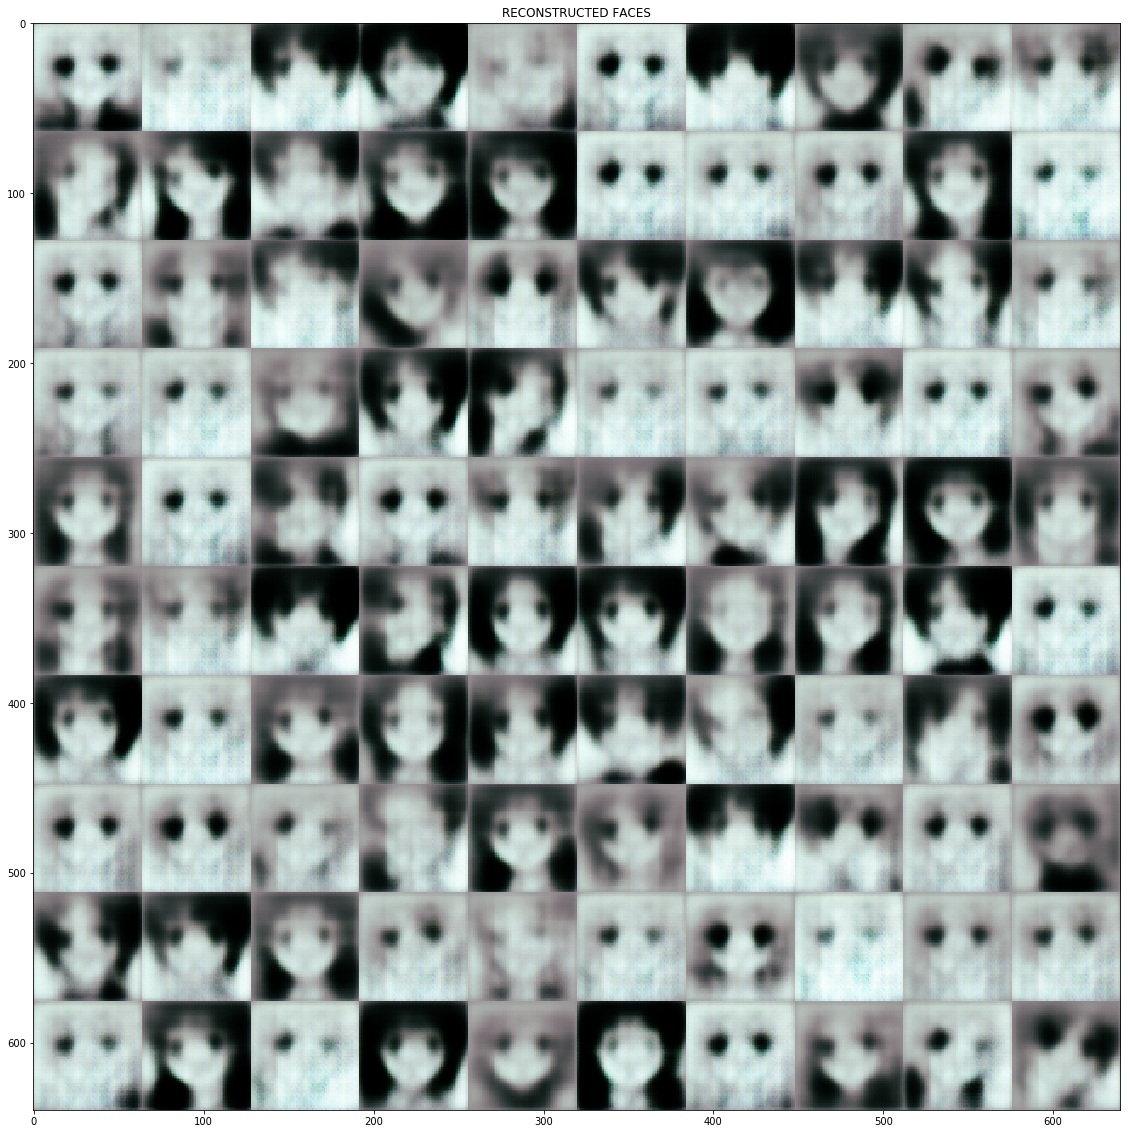

In [33]:
# RECONSTRUCTION OF ORIGINAL IMAGES

predictions  = vae.predict(x_data[:100])
plot_images(10,10,predictions, "RECONSTRUCTED FACES")

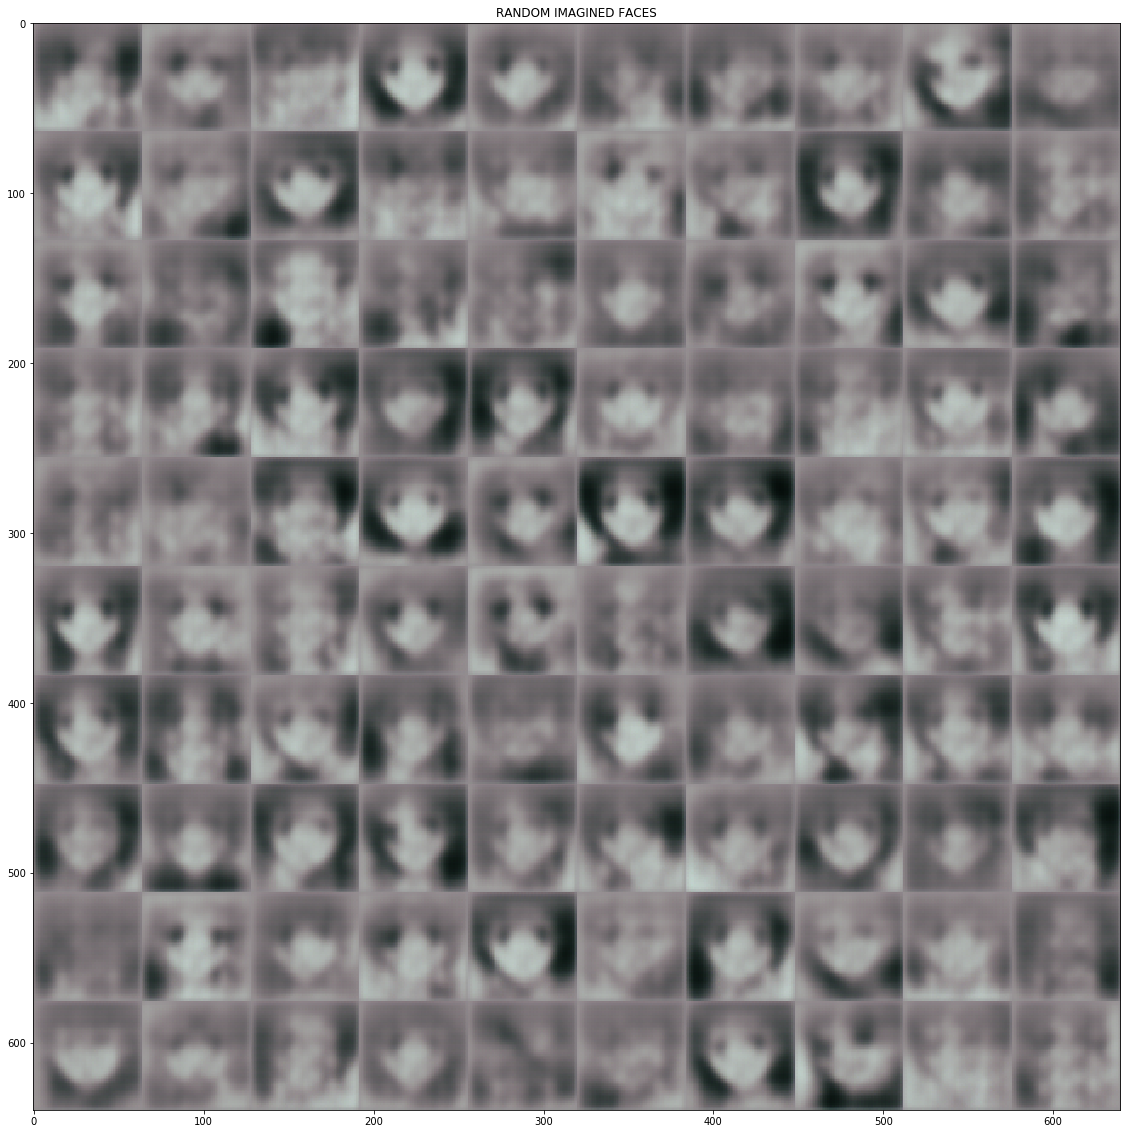

In [34]:
#NEW FACES GENERATED FROM RANDOM NOISE

predictions= decoder.predict(np.random.randn(100, latent_dims))
plot_images(10,10,predictions, "RANDOM IMAGINED FACES")

## Improvements

* Play around with the general architecture of the encoder and decoder. More layers? bigger layers?   
* Increase the number of latent dimensions. My intuition says more dimension will help the reconstruction of original images, but may result in a sparser latent space resulting in poorer newly generated images. 
* Investigate the best way to implement kl_loss and reconstruction_loss, so as not have to add a scalling factor. 
